<a href="https://colab.research.google.com/github/kskaran94/CNN_-_TransferLearning/blob/master/CNN_and_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following script has been written in Google colab notebook. 
The data set is available on kaggle. The aim of the script is not to get a perfect score on Kaggle leaderboard but to understand Convolution Neural Networks and Transfer learning.  I have used only the train dataset here. 


## **Libraries Imported**

In [0]:
from google.colab import files
import json
from glob import glob
import fnmatch
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Dense, \
Dropout, Input, add
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import roc_auc_score
import os
import shutil
import warnings
warnings.filterwarnings('ignore')


In [2]:
uploaded = files.upload()


Saving kaggle.json to kaggle.json


## **Reading Data**

Downloading data from kaggle . If you have this data available , then you can skip this code cell

In [5]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

token = {"username":"kskaran94","key":"67ffe4a038a3668b565ca33b1a78dd01"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
    
! chmod 600 /root/.kaggle/kaggle.json

! kaggle competitions download -c aerial-cactus-identification

  0% 0.00/667k [00:00<?, ?B/s]
100% 667k/667k [00:00<00:00, 45.5MB/s]
  0% 0.00/160k [00:00<?, ?B/s]
100% 160k/160k [00:00<00:00, 54.1MB/s]
  0% 0.00/4.20M [00:00<?, ?B/s]
100% 4.20M/4.20M [00:00<00:00, 69.1MB/s]
 47% 9.00M/19.2M [00:00<00:00, 59.2MB/s]
100% 19.2M/19.2M [00:00<00:00, 93.8MB/s]


In [0]:
! unzip /content/train.zip
! unzip /content/test.zip

Read the target csv, which contains image url and the label. This csv will help us reorganize the data.

In [7]:
target_csv = pd.read_csv('/content/train.csv')
target_csv.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


Re-arranging the data and moving it into a target based folder structure

In [0]:

!mkdir /content/data/
!mkdir /content/data/0/
!mkdir /content/data/1/


urls_1 = target_csv[target_csv['has_cactus']==1]['id'].values
urls_0 = target_csv[target_csv['has_cactus']==0]['id'].values



for file in urls_0:
    shutil.copy('/content/train/'+ file, '/content/data/0/')

for file in urls_1:
    shutil.copy('/content/train/'+ file, '/content/data/1/')

## **Data Transformation**

Reading a sub sample of class 0 images and re -sizing them with height and width=50. The images are read in X and the labels in Y. The same process is repeated for class 1 images.

All the images have to be of the same size , hence the resizing is necessary.

In [0]:
x = []
y = []
WIDTH = 50
HEIGHT = 50

for img in urls_0:
    full_size_image = cv2.imread('/content/data/0/'+img)
    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), 
                      interpolation=cv2.INTER_CUBIC))
    y.append(0)
    
for img in urls_1:
    full_size_image = cv2.imread('/content/data/1/'+img)
    x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), 
                      interpolation=cv2.INTER_CUBIC))
    y.append(1)

Preprocessing of images: Dividing image by 255 for standarization. We could also transform the images from RGB to gray scale.

Dividing the images into train and test with stratified sampling. So the distribution across train and test remain the same

## **Train-test split**

In [10]:
X=np.array(x)
X = X/255

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify = y)



print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (14000, 50, 50, 3)
Testing Data Shape: (3500, 50, 50, 3)


## **Base Model**

Defining the neural network: For simplicity of the problem I have kept 2 convolution layers with kernel_size (3,3), followed by batch normalization ,Max pooling of (2,2) and Dropout.

The drop out parameter , Max pool size can be tuned but due to restriction of computational resources , I was unable to. The same can be said for kernel size.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 12600 samples, validate on 1400 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
 - 5s - loss: 0.4195 - acc: 0.8722 - val_loss: 2.3932 - val_acc: 0.2664
Epoch 2/30
 - 2s - loss: 0.1717 - acc: 0.9413 - val_loss: 2.2641 - val_acc: 0.2664
Epoch 3/30
 - 2s - loss: 0.1421 - acc: 0.9487 - val_loss: 1.2960 - val_acc: 0.3707
Epoch 4/30
 - 2s - loss: 0.1220 - acc: 0.9545 - val_loss: 0.8175 - val_acc: 0.6414
Epoch 5/30
 - 2s - loss: 0.1159 - acc: 0.9573 - val_loss: 0.4337 - val_acc: 0.8143
Epoch 6/30
 - 2s - loss: 0.1049 - acc: 0.9594 - val_loss: 0.1196 - val_acc: 0.9543
Epoch 7/30
 - 2s - loss: 0.1039 - acc: 0.9598 - val_loss: 0.1324 - val_acc: 0.9400
Epoch 8/30
 - 2s - loss: 0.0951 - acc: 0.9651 - val_loss: 0.4485 - val_acc: 0.8536
Epoch 9/30
 - 2s - loss: 0.0923 - acc: 0.9660 - val_

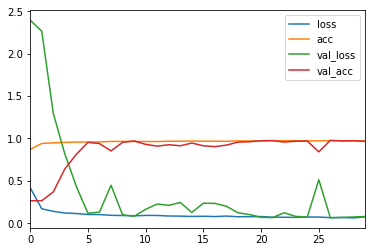

In [11]:
num_classes = 2
input_shape = (50, 50, 3)


cnn_small_bn = Sequential([
    Conv2D(8, kernel_size = (3,3), input_shape=input_shape, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(.5),
    Conv2D(8, kernel_size = (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(.5),
    Flatten(),
    Dense(num_classes, activation='softmax'),
                 ])

y_train = to_categorical(Y_train, num_classes)
y_test = to_categorical(Y_test, num_classes)

cnn_small_bn.compile("adam", "binary_crossentropy", metrics=['accuracy'])
history_cnn = cnn_small_bn.fit(X_train, y_train,
                      batch_size=128, epochs=30, verbose=2, validation_split=.1)
pd.DataFrame(history_cnn.history).plot()

The model performs well on both the train and validation tests.

### **Test Evaluation of Base Model**

As the data we have is an unbalanced class data, I am using roc-auc as an evaluation metric .

In [15]:
roc_auc_score(Y_test,cnn_small_bn.predict_classes(X_test))

0.9742948262623012